# Machine Learning With Text : Sentiment Analysis

This is the first cut at a series of exercises to conduct sentiment analysis for the Microsoft Reactor Machine Learning initiative. Machine learning does not just have to be about numbers. We can turn text into numbers and look at things like document similarity, clusters, etc. We can also engage Natural Language Processing (NLP) tools to perform sentiment analysis, named entity recognition and more.

Consider the explosion of data we face and then realize that we have similar issues with documents in the form of news stories or magazine articles. You either need to read very fast (or constantly) or rely on some reporting source to tell you what is going on. It is clear that not every news story is unbiased and sometimes there may be positive or negative spin on a story, so how do you look behind the scenes to see what is going on?

We can increasingly rely on machine learning systems to help us process documents and extract information and other value from them. If you work in a particular industry, you could start to see what is being said about your industry. If you have an investment portfolio, you could imagine letting software read the news and draw your attention to positive or negative swings in reporting. If you work for an organization, you could get a sense of what people were saying about you on social media.

In our exercise, we will use an RSS feed of the news headlines from Microsoft Money as a source of data. As time passes, you could store and assess what is the general sentiment of the news? Who is being mentioned most often? Are positive and negative things being said about these individuals, organizations or places?

PLEASE NOTE: THE RESULTS OF THIS EXERCISE WILL CHANGE OVER TIME AND DO NOT CONSTITUTE LEGAL OR FINANCIAL ADVICE. PLEASE CONSULT WITH YOUR OWN EXPERTS BEFORE MAKING ANY DECISIONS ON WHAT YOU READ IN THE NEWS OR SEE HERE.

You will need to install BeautifulSoup, nltk and feedparser.

In [1]:
import feedparser
import requests
import hashlib
import tempfile
import os
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk import tokenize
import numpy as np

# We need to load the lexicons that the VADER algorithm uses to assess sentiment.

nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We do not want to hammer any websites or RSS feeds, so the first couple of functions will cache the feeds locally in a temporary directory. This first one makes sure that the temporary directory we are expecting exists.

In [2]:
def createTempDirIfNecessary() :
    tempDir = tempfile.gettempdir()
    path = os.path.join(tempDir, "msft-reactor-ml")

    if(not os.path.exists(path)) :
        os.mkdir(path)

    return path

We hash a URL and use that as the basis of the file identity in our temporary directory. If we already have a file with this name, we won't try to fetch it again. Removing the temporary file will force it to be re-fetched.

TODO:
* Fetch hashed files if they are over some threshold of days old to keep the feed relatively up-to-date.

In [3]:
def fetchUrlIfNecessary(url) :
    path = createTempDirIfNecessary()

    hashed = hashlib.sha256(url.encode()).hexdigest()

    file = os.path.join(path, f"{hashed}.in.txt")

    if(not os.path.exists(file)) :
        response = requests.get(url)
        with open(file, mode='wb') as localfile:
            localfile.write(response.content)

    return file

This function strips non-text-related structures from the fetched HTML files (e.g. scripts, style tags, links, etc.) to result in relatively clean text.

In [4]:
# https://stackoverflow.com/questions/30565404/remove-all-style-scripts-and-html-tags-from-an-html-page/30565420

def cleanMe(html):
    soup = BeautifulSoup(html, "html.parser") # create a new bs4 object from the html data loaded
    for script in soup(["script", "style", "a", "li"]): # remove all javascript and stylesheet code
        script.extract()
    # get text
    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text

This function iterates over all of the feed elements, fetches them if need be, cleans up the text and dumps out the text files for future processing.

In [5]:
feedFile = fetchUrlIfNecessary("http://rss.msn.com/en-us/money?feedoutput=rss")
feed = feedparser.parse(f"file:///{feedFile}")

results = []

for post in feed.entries:
    print(f"Fetching: {post.link}")
    
    entryFile = fetchUrlIfNecessary(post.link)

    with open (entryFile, "r" ) as myfile:
        data = myfile.read()
        data = cleanMe(data)

        outfile = open(f"{entryFile}.out.txt", "w")
        outfile.write(data)
        outfile.close()

Fetching: http://www.msn.com/en-us/money/realestate/getting-a-mortgage-payment-break-isnt-the-boon-many-expected/ar-BB1351Eh?srcref=rss
Fetching: http://www.msn.com/en-us/money/realestate/why-the-latest-housing-numbers-are-worse-than-they-look/ar-BB132UWG?srcref=rss
Fetching: http://www.msn.com/en-us/money/taxes/15-states-that-dont-tax-unemployment-benefits/ss-BB136sp4?srcref=rss
Fetching: http://www.msn.com/en-us/money/savemoney/from-guns-to-jigsaws-surprising-things-the-world-is-buying-in-lockdown/ss-BB135Efd?srcref=rss
Fetching: http://www.msn.com/en-us/money/topstocks/harvard-professor-reaps-17000percent-return-on-early-moderna-bet/ar-BB1337ml?srcref=rss
Fetching: http://www.msn.com/en-us/money/retirement/researchers-find-covid-19-is-pushing-americans-into-early-retirement/ar-BB134R4q?srcref=rss
Fetching: http://www.msn.com/en-us/money/credit/credit-cards-cutting-limits-for-people-facing-tough-times/ar-BB134R1n?srcref=rss
Fetching: http://www.msn.com/en-us/money/markets/stocks-fluc

This is a sample cell for showing the steps for analysis of one text file. We iterate over the sentences and print out the Vader sentiment polarity scores per sentence.

In [6]:
from nltk import tokenize

feedFile = fetchUrlIfNecessary("http://rss.msn.com/en-us/money?feedoutput=rss")
feed = feedparser.parse(f"file:///{feedFile}")
postFile = fetchUrlIfNecessary(feed.entries[0].link)

with open(postFile, "r") as f:
    data = f.read()
    data = cleanMe(data)
    sentences = tokenize.sent_tokenize(data)

    sid = SentimentIntensityAnalyzer()
    for sentence in sentences:
        print(sentence)
        ss = sid.polarity_scores(sentence)
        for k in sorted(ss):
            print('{0}: {1}, '.format(k, ss[k]), end='')
        print()




Getting a Mortgage-Payment Break Isn't the Boon Many Expected
You are using an older browser version.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
Please use a
for the best MSN experience.
compound: 0.7579, neg: 0.0, neu: 0.435, pos: 0.565, 
Getting a Mortgage-Payment Break Isn't the Boon Many Expected
5 hrs ago
Paul Kiernan
© Steve Dipaola/Reuters
WASHINGTON—A government effort to give Americans a break on their mortgage payments during the coronavirus pandemic hasn’t provided the relief many homeowners were hoping for.The stimulus package that Congress passed in March allows homeowners with federally-backed loans to suspend monthly payments for up to a year without penalty, if they face financial hardship.But the law doesn’t specify what happens after the so-called forbearance period ends.
compound: 0.7253, neg: 0.027, neu: 0.872, pos: 0.1, 
Many borrowers say they are being told they will have to make lump-sum “balloon” payments.“They want to make it as difficult as possible for pe

We are going to start by iterating over all of the cached feeds and do sentiment analysis on the feed entry titles with an analyzer from the NLTK. This tool calculates the positive, negative, neutral and compound scores per headline. We accumulate the results for further analysis later to be put into a Pandas DataFrame.

In [7]:
feedFile = fetchUrlIfNecessary("http://rss.msn.com/en-us/money?feedoutput=rss")
feed = feedparser.parse(f"file:///{feedFile}")

results = []
sid = SentimentIntensityAnalyzer()

for post in feed.entries:
    print(f"Analyzing: {post.title}")

    scores = sid.polarity_scores(post.title)
    scores['title'] = post.title

    print(f"compound: {scores['compound']}")
    print(f"neg: {scores['neg']}")
    print(f"neu: {scores['neu']}")
    print(f"pos: {scores['pos']}")
    print()

    results.append(scores)



Analyzing: A mortgage break isn't the boon many people expected
compound: 0.0
neg: 0.0
neu: 1.0
pos: 0.0

Analyzing: The latest housing numbers are worse than they look
compound: -0.4767
neg: 0.279
neu: 0.721
pos: 0.0

Analyzing: These states don't tax unemployment benefits
compound: 0.0572
neg: 0.254
neu: 0.466
pos: 0.28

Analyzing: Surprising things the world is buying in lockdown
compound: 0.2732
neg: 0.0
neu: 0.769
pos: 0.231

Analyzing: Harvard prof reaps 17,000% return on early vaccine bet
compound: 0.0
neg: 0.0
neu: 1.0
pos: 0.0

Analyzing: The pandemic is pushing Americans into early retirement
compound: 0.0
neg: 0.0
neu: 1.0
pos: 0.0

Analyzing: Credit cards cutting limits for people facing tough times
compound: 0.1531
neg: 0.259
neu: 0.517
pos: 0.224

Analyzing: Stocks waver on news of possible virus treatment
compound: 0.0
neg: 0.0
neu: 1.0
pos: 0.0

Analyzing: These things might not survive the pandemic
compound: 0.0
neg: 0.0
neu: 1.0
pos: 0.0

Analyzing: 'I did not sign up

As you may have seen in the Microsoft Reactor Data Science workshops, Pandas DataFrames are useful for manipulating data. We will build an instance from our collected results.

In [8]:
import pandas as pd 
df = pd.DataFrame.from_records(results)
df.head()

,compound,neg,neu,pos,title
0,0.0000,0.000,1.000,0.000,A mortgage break isn't the boon many people ex...
1,-0.4767,0.279,0.721,0.000,The latest housing numbers are worse than they...
2,0.0572,0.254,0.466,0.280,These states don't tax unemployment benefits
3,0.2732,0.000,0.769,0.231,Surprising things the world is buying in lockdown
4,0.0000,0.000,1.000,0.000,"Harvard prof reaps 17,000% return on early vac..."


The sentiment analysis tool defines a range of values between -1.0 and 1.0 representating very negative to very positive values. This function establishes a threshold below which, we will consider to be a negative score. Anything above the threshold will be considered a positive score. Values in-between the positive and negative scores, we will be consider them to be neutral. We will return a score of 1 for positive, 0 for neutral and -1 for negative results. Feel free to change these thresholds to what makes sense to you.

In [10]:
def label_lambda(x):
    retVal = 0

    if (x < 0.3) & (x > -0.3):
        retVal = 0
    elif x >= 0.3:
        retVal = 1
    else:
        retVal = -1

    return retVal

We will add a label feature to our DataFrame by applying our lambda function to the compund sentiment rating.

In [11]:

df['label'] = df['compound'].apply(label_lambda)
df.head()

,compound,neg,neu,pos,title,label
0,0.0000,0.000,1.000,0.000,A mortgage break isn't the boon many people ex...,0
1,-0.4767,0.279,0.721,0.000,The latest housing numbers are worse than they...,-1
2,0.0572,0.254,0.466,0.280,These states don't tax unemployment benefits,0
3,0.2732,0.000,0.769,0.231,Surprising things the world is buying in lockdown,0
4,0.0000,0.000,1.000,0.000,"Harvard prof reaps 17,000% return on early vac...",0


Grab the numeric columns for cluster analysis.

In [12]:
df2 = df[['compound', 'neg', 'neu', 'pos']]
df2.head()

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,-0.4767,0.279,0.721,0.000
2,0.0572,0.254,0.466,0.280
3,0.2732,0.000,0.769,0.231
4,0.0000,0.000,1.000,0.000


Cluster the sentences based on their numbers using SciKit-Learn and its K-Means implementation. Consider the implications of different numbers of clusters.

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df2.values)

kmeans.labels_

array([1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0,
       1, 2, 1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 0, 0, 2,
       1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 1, 2,
       1, 0, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1],
      dtype=int32)

It might be interesting to visualize the clusters and compare the texts. For now, let's just add the label feature to our DataFrame as well.

In [15]:
df['cluster'] = kmeans.labels_
df.head()

,compound,neg,neu,pos,title,label,cluster
0,0.0000,0.000,1.000,0.000,A mortgage break isn't the boon many people ex...,0,1
1,-0.4767,0.279,0.721,0.000,The latest housing numbers are worse than they...,-1,0
2,0.0572,0.254,0.466,0.280,These states don't tax unemployment benefits,0,2
3,0.2732,0.000,0.769,0.231,Surprising things the world is buying in lockdown,0,2
4,0.0000,0.000,1.000,0.000,"Harvard prof reaps 17,000% return on early vac...",0,1


In [ ]:
We can analyze the average compound sentiment ratings for each of the clusters. Unsurprisingly, we have found clusters of mostly positive, neutral or negative texts.

In [16]:
cluster_zero = df[df.cluster==0]['compound'].mean()
cluster_one = df[df.cluster==1]['compound'].mean()
cluster_two = df[df.cluster==2]['compound'].mean()

print(f"Average compound score for cluster 0: {cluster_zero}")
print(f"Average compound score for cluster 1: {cluster_one}")
print(f"Average compound score for cluster 2: {cluster_two}")


Average compound score for cluster 0: -0.4147136363636364
Average compound score for cluster 1: 0.004927419354838709
Average compound score for cluster 2: 0.34895600000000004


In [ ]:
Pandas allows us to easily look at average values for all of our features, not just the compound values.

In [17]:
# Average values for all metrics in cluster 0
df[df.cluster==0].mean()

compound   -0.414714
neg         0.295773
neu         0.672136
pos         0.032136
label      -0.681818
cluster     0.000000
dtype: float64

In [162]:
# Average values for all metrics in cluster 1
df[df.cluster==1].mean()

compound    0.004989
neg         0.005446
neu         0.983661
pos         0.010893
label       0.000000
cluster     1.000000
dtype: float64

In [ ]:
Let's visualize the clusters using the popular Matplotlib library. We need to import the functionality, but we also need to tell Jupyter Notebooks to render the results inline.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

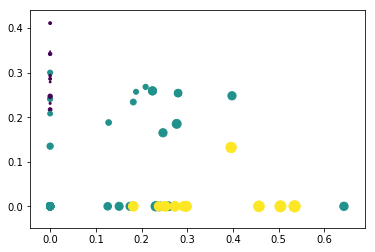

In [27]:
plt.scatter(df['pos'], df['neg'], s=(100 * df['compound'] + 50), c=df['label'])

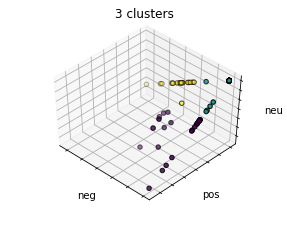

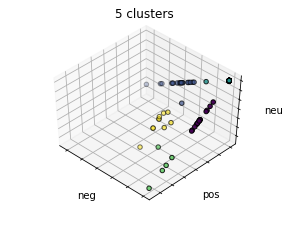

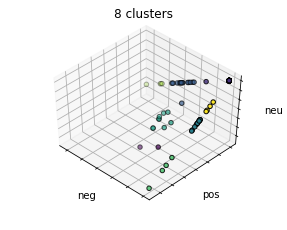

In [28]:
from mpl_toolkits.mplot3d import Axes3D

estimators = [('k_means_3', KMeans(n_clusters=3)),
              ('k_means_5', KMeans(n_clusters=5)),
              ('k_means_8', KMeans(n_clusters=8))]

X = df2 = df[['neg', 'neu', 'pos']].values

fignum = 1
titles = ['3 clusters', '5 clusters', '8 clusters']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 0], X[:, 2], X[:, 1],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('neg')
    ax.set_ylabel('pos')
    ax.set_zlabel('neu')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1



We are now going to use Microsoft's Cognitive Services Text Analytics Services for even more functionality that can scale up to larger datasets. You will need to install the Python Text Analytics client:

pip install --upgrade azure-cognitiveservices-language-textanalytics

The following block will require you supply a key and endpoint that you would have been given when you registered for a Free Account. Please supply these values for you below. These will then be used to authenticate the client to the service. You will be able to use the client in cells below.

NOTE: PLEASE DO NOT CHECK IN JUPYTER NOTEBOOKS WITH PRIVATE KEYS IN THEM TO CHANGE MANAGEMENT SYSTEMS SUCH AS GIT!!!

In [18]:

# key = ADD_YOUR_KEY_HERE
# endpoint = ADD_YOUR_ENDPOINT_URL_HERE

import os
from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

def authenticateClient():
    credentials = CognitiveServicesCredentials(key)
    text_analytics_client = TextAnalyticsClient(
        endpoint=endpoint, credentials=credentials)
    return text_analytics_client

client = authenticateClient()

We are now going to process our headlines through the Text Analytics APIs.

The general structure the APIs expect is something like:

{
    "id" : 0,
    "text" : "The body of text you wish to analyze."
}

So, we will build this structure. Some of the services want to know the source language (e.g. 'en', 'jp', 'fr'). We do not have this information yet, so we will rely on the language detection service to decide this for us. 

After this we conduct a sentiment analysis on the body of the text. This will give us a numeric summary between 0.0 (negative) and 1.0 (positive).

Finally, we will find the key phrases in the titles as well. 

In [19]:
feedFile = fetchUrlIfNecessary("http://rss.msn.com/en-us/money?feedoutput=rss")
feed = feedparser.parse(f"file:///{feedFile}")

documents = []
i = 0

for post in feed.entries:
    print(f"Analyzing: {post.title}")
    documents.append({'text' : post.title, "id" : i})
    i += 1

response = client.detect_language(documents=documents)

for document in response.documents:
   documents[int(document.id)]['language'] = document.detected_languages[0].iso6391_name

response = client.sentiment(documents=documents)

for document in response.documents:
    documents[int(document.id)]['sentiment'] = document.score

response = client.key_phrases(documents=documents)

for document in response.documents:
    documents[int(document.id)]['keyphrases'] = document.key_phrases

print(documents)


yzing: 20 industries that will never be the same after the coronavirus
Analyzing: How grocery stores have fared during the pandemic
Analyzing: These retailers and restaurants may not survive coronavirus
Analyzing: Iconic US brands that aren't made in America
Analyzing: Cities where home prices plummeted as early as February
Analyzing: Predictions on when we will bounce back from COVID-19
Analyzing: How America's biggest companies are impacted by COVID-19
Analyzing: Netflix's incredible rise from rentals to ruling the world
Analyzing: The number of COVID-19 cases per capita in each state
Analyzing: These products are coming back to store shelves soon
Analyzing: 10 things to know about filing for unemployment
Analyzing: 50 remote jobs that can pay well
Analyzing: Where the coronavirus recession will likely hit hardest
Analyzing: Restaurant chains that are closing locations
Analyzing: These states are the most financially prepared for a recession
Analyzing: Countries with the most debt
An

One of the interesting things we can do is find references to specific individuals, organizations or places. These discovered entities will be tagged as being of type 'Person' or 'Organization'. This is useful metadata that we could use to do further analysis. We will filter out less meaningful types such as 'Quantity' or 'DateTime'. We add these entity types to our document records.

In [20]:
response = client.entities(documents=documents)

for document in response.documents:
    entities = []

    for entity in document.entities:
        if entity.type != 'Quantity' and entity.type != 'DateTime':
            entities.append({'name' : entity.name, 'type' : entity.type, 'subtype' : entity.sub_type })

    documents[int(document.id)]['entities'] = entities

print(documents)

'id': 20, 'language': 'en', 'sentiment': 0.5, 'keyphrases': ['news of possible virus treatment', 'Stocks waver'], 'entities': []}, {'text': 'The latest housing numbers are worse than they look', 'id': 21, 'language': 'en', 'sentiment': 0.00920066237449646, 'keyphrases': ['latest housing numbers'], 'entities': []}, {'text': "Whopping jobless numbers still don't tell the whole story", 'id': 22, 'language': 'en', 'sentiment': 0.21789979934692383, 'keyphrases': ['Whopping jobless numbers', 'story'], 'entities': []}, {'text': 'Millions join unemployed ranks as virus ravages economy', 'id': 23, 'language': 'en', 'sentiment': 0.1355624794960022, 'keyphrases': ['unemployed ranks', 'virus ravages economy', 'Millions'], 'entities': []}, {'text': 'State and city workers could be the next wave of layoffs', 'id': 24, 'language': 'en', 'sentiment': 0.5, 'keyphrases': ['city workers', 'wave of layoffs', 'State'], 'entities': [{'name': 'State', 'type': 'Organization', 'subtype': None}]}, {'text': 'Oil

In [ ]:
We will allow people to ask questions about positive or negative references to different types of entities.

In [21]:
def addReference(refs, key, sentiment, text):
   currentRefs = refs.get(key, {'sentiment' : [], 'headline' : []})
   currentRefs['sentiment'].append(document['sentiment'])
   currentRefs['headline'].append(document['text'])
   refs[key] = currentRefs


In [22]:
def averageSentimentValue(ratings) :
    return np.array(ratings).mean()

def entitySummary(entityType, refs, polarity):
    print(f"{entityType} with the most {polarity} coverage:")

    for entity in refs.keys() :
        print('---------------')
        print(f"Name: {entity}")
        avg = averageSentimentValue(refs[entity]['sentiment'])
        print(f" .  Average sentiment analysis: {avg}")
        headlines = refs[entity]['headline']
        print(" .  Headlines:")
        for h in headlines:
            print(f"      {h}")

    print()

We will now keep track of which entities are referenced the most and who has the most positive and negative references.

In [23]:
entityCount = {}
entityTypeCount = {}
posPersonRefs = {}
negPersonRefs = {}
posOrgRefs = {}
negOrgRefs = {}

for document in documents:
    for entity in document['entities']:
        name = entity['name']
        t = entity['type']
        count = entityCount.get(name, 0)
        entityCount[name] = count + 1
        count = entityTypeCount.get(t, 0)
        entityTypeCount[t] = count + 1

        if document['sentiment'] >= 0.6:
            # Add the positive references
            if t == 'Person' :
                print(f"Adding + person reference for {name}")
                addReference(posPersonRefs, name, document['sentiment'], document['text'])
            elif t == 'Organization' :
                print(f"Adding + org reference for {name}")
                addReference(posOrgRefs, name, document['sentiment'], document['text'])

        elif document['sentiment'] <= 0.4:
            # Add the negative references
            if t == 'Person' :
                print(f"Adding - person reference for {name}")
                addReference(negPersonRefs, name, document['sentiment'], document['text'])
            elif t == 'Organization' :
                print(f"Adding - org reference for {name}")
                addReference(negOrgRefs, name, document['sentiment'], document['text'])


Adding - org reference for Costco
Adding - org reference for Netflix
Adding + org reference for Chipotle Mexican Grill
Adding - org reference for UK
Adding - org reference for Delta Airlines
Adding + org reference for Nasdaq
Adding + org reference for Saving & Spending
Adding - org reference for Costco
Adding + org reference for LinkedIn
Adding + org reference for Chipotle
Adding + org reference for Netflix
Adding + person reference for Jim Cramer
Adding + org reference for Iconic US
Adding + org reference for Netflix
Adding + org reference for Company (military unit)


We can now summarize the most positive and negative mentions of People and Organizations.

In [24]:
entitySummary('People', posPersonRefs, 'positive')
entitySummary('People', negPersonRefs, 'negative')
entitySummary('Organizations', posOrgRefs, 'positive')
entitySummary('Organizations', negOrgRefs, 'negative')


People with the most positive coverage:
---------------
Name: Jim Cramer
 .  Average sentiment analysis: 0.9144583344459534
 .  Headlines:
      Stocks of 'good corporate citizens' such as Chipotle, Netflix are thriving, Jim Cramer says

People with the most negative coverage:

Organizations with the most positive coverage:
---------------
Name: Chipotle Mexican Grill
 .  Average sentiment analysis: 0.868740439414978
 .  Headlines:
      Chipotle handling pandemic much better than other chains
---------------
Name: Nasdaq
 .  Average sentiment analysis: 0.8922896385192871
 .  Headlines:
      Nasdaq 'hopeful' that larger IPOs are around the corner
---------------
Name: Saving & Spending
 .  Average sentiment analysis: 0.7526739239692688
 .  Headlines:
      Saving & Spending
---------------
Name: LinkedIn
 .  Average sentiment analysis: 0.7435328960418701
 .  Headlines:
      LinkedIn: These companies are hiring now
---------------
Name: Chipotle
 .  Average sentiment analysis: 0.91445

We are still operating in Jupyter notebooks, so we can do some Python code to visualize which entities are mentioned the most in the news.

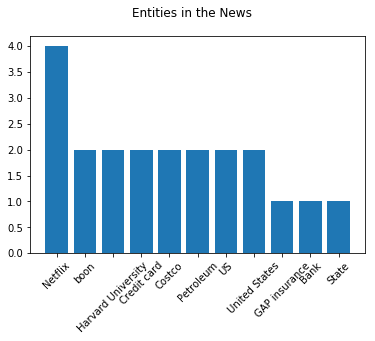

In [29]:
topEntities = {}
n = 10

count = 0

for w in sorted(entityCount, key=entityCount.get, reverse=True):
   topEntities[w] = entityCount[w]
   count = count + 1
   if count > n:
       break

fig, axs = plt.subplots(1)
fig.suptitle('Entities in the News')
labels = list(topEntities.keys())
axs.bar(labels, topEntities.values())
axs.set_xticklabels(labels, rotation=45)
plt.show()


We could also keep track of which types of entities are being mentioned in the news.

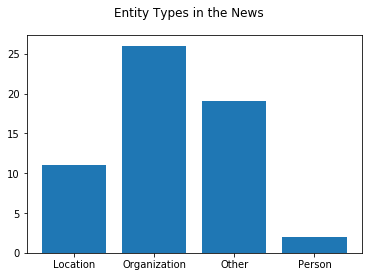

In [30]:
fig, axs = plt.subplots(1)
fig.suptitle('Entity Types in the News')
axs.bar(list(entityTypeCount.keys()), entityTypeCount.values())
plt.show()